In [1]:
import sys
sys.path.insert(0, "/home/ubuntu/data/code/Modules/")

In [2]:
import skimage
import numpy as np
import pickle
import gc
from albumentations import Compose,HorizontalFlip, VerticalFlip, ToFloat
from sklearn.metrics import confusion_matrix
import cv2
import matplotlib.pyplot as plt
from keras import backend
from keras.models import Sequential
from keras.losses import binary_crossentropy
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, BatchNormalization, Flatten, Dropout
from keras.optimizers import SGD,Adadelta
import DataGenerator
from albumentations import Compose,HorizontalFlip, VerticalFlip, ToFloat
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import random
import glob
import CNN_Module as cnn_module
import models
import glue_code

Using TensorFlow backend.


In [3]:
import imp
imp.reload(cnn_module)
imp.reload(models)
imp.reload(DataGenerator)

<module 'DataGenerator' from '/home/ubuntu/data/code/Modules/DataGenerator.py'>

In [4]:
augment_train, augment_valid = cnn_module.get_augmentations_train_test()
params_train, params_test = cnn_module.get_params_train_test(80,augment_train,augment_valid)#both augment_valid for no flipping else 1 augment_train
params_test['batch_size']=32
print(params_test)

{'dim': (80, 80), 'batch_size': 32, 'n_classes': 2, 'augmentations': Compose([
  ToFloat(always_apply=False, p=1.0, max_value=65535),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}), 'n_channels': 1, 'shuffle': False}


In [5]:
#prep cells for feeding into CNN
control_cells = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/control/'))
sus_cells     = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/susceptible/'))

#label cells, and split cells into test and train, making sure to have equal proportion of sus and ctrl in both
control_cells_label = cnn_module.create_label_dict(control_cells,0)
sus_cells_label  = cnn_module.create_label_dict(sus_cells,1)

train_labels = list(control_cells_label.items())+list(sus_cells_label.items())

print(len(control_cells))
print(len(sus_cells))

156
351


In [6]:
paths_train = np.array(train_labels)[:,0]
labels_train= np.array(train_labels)[:,1].astype('int')
##split into image labels and paths
video_path = '/cropped_video80'
sample_gap=10
im_paths_train, im_labels_train = cnn_module.sample_label_images_in_cells(paths_train,video_path,labels_train,sample_gap)
#get a reference dict with all labels for every image
im_labels_train_reference = dict(zip(im_paths_train,im_labels_train))

In [7]:
def reset_weights(model):
    session = backend.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)
            


In [10]:
result = []
model = models.get_luke_model(80)
for cell_number in np.arange(50,150,50):
    cell_number_result = []
    
    for repeat in np.arange(3):
        print('cell number =',cell_number)
        print('repeat number =',repeat)
        
        random.shuffle(train_labels)
        #split cells into controlled number of test and train
        total_cells = train_labels[:cell_number]
        #print(total_cells)
        
        ##for a 90:10 split use below
        #train_cells = total_cells[0:(int((cell_number)*0.9))]
        #test_cells = total_cells[(int((cell_number)*0.9)):]
        
        ##Our original method of splitting, using all cells each time
        train_cells = train_labels[:(cell_number)]
        test_cells = train_labels[cell_number:]
        #print(train_cells)
        
        print('train =',len(train_cells))
        print('test =',len(test_cells))
        
        #split cells into images
        cells_train = np.array(train_cells)[:,0]
        labels_train= np.array(train_cells)[:,1].astype('int')
        ##split into image labels and paths
        im_paths_train, im_labels_train = cnn_module.sample_label_images_in_cells(cells_train,video_path,labels_train,sample_gap)
        ##make labels into path -> label dict as generator requires
        im_labels_train = dict(zip(im_paths_train,im_labels_train))
        
        ##repeat for test_cells
        cells_test = np.array(test_cells)[:,0]
        labels_test= np.array(test_cells)[:,1].astype('int')
        im_paths_test, im_labels_test = cnn_module.sample_label_images_in_cells(cells_test,video_path,labels_test,sample_gap)
        im_labels_test = dict(zip(im_paths_test,im_labels_test))
        #set up generators
        training_generator = DataGenerator.DataGenerator(im_paths_train, im_labels_train, **params_train)
        prediction_generator = DataGenerator.DataGenerator(im_paths_test, im_labels_test, **params_test)
        
        ##fit model
        sample_gap=10
        epochs=5
        stepsperepoch=100
        video_path = '/cropped_video80'
        validate_steps = len(im_paths_test)//32
        model.fit_generator(generator=training_generator,epochs = epochs,steps_per_epoch=stepsperepoch,verbose=1)
        #print(model.fit_generator(generator=training_generator,epochs = epochs,steps_per_epoch=stepsperepoch,verbose=0))
        #make predictions
        preds = model.predict_generator(generator=prediction_generator,workers=1,steps = len(im_paths_test)//32, use_multiprocessing=False)
        filenames_preds = dict(zip(prediction_generator.filenames,preds))   
    
        #find accuracies
        im_result = [(im_labels_train_reference[key],np.argmax(filenames_preds[key])) for key in filenames_preds.keys()]
        image_accuracy = accuracy_score(np.array(im_result)[:,0],np.array(im_result)[:,1])
        
        split = glue_code.split_preds_into_cells(filenames_preds,np.array(test_cells)[:,0])
        #as predict_generator is broken - sometime misses the last few images, we need to make sure that none of our
        #cells have 0 images
        split = [i for i in split if len(i)>0]
        
        cell_predictions = np.array(glue_code.get_cell_predictions(split,filenames_preds))
        #need to make sure that the true test cell labels we compare against actually exist in cell predictions, so grab all those that do
        labels_test_p = [dict(test_cells)[i] for i in cell_predictions[:,0]]#
        cell_accuracy = accuracy_score(labels_test_p,np.rint(cell_predictions[:,2].astype('float')))
        #print(image_accuracy,cell_accuracy)
        cell_number_result.append((cell_number,image_accuracy,cell_accuracy))
        reset_weights(model)
        
    result.append(cell_number_result)
    print(np.average(np.array(cell_number_result)[:,1]),np.average(np.array(cell_number_result)[:,2]))













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
cell number = 50
repeat number = 0
train = 50
test = 457


Epoch 1/5
100/100 [==============================] - 7s 72ms/step - loss: 1.0665 - acc: 0.7169
Epoch 2/5
100/100 [==============================] - 3s 27ms/step - loss: 0.2987 - acc: 0.8897
Epoch 3/5
100/100 [==============================] - 3s 27ms/step - loss: 0.1586 - acc: 0.9437
Epoch 4/5
100/100 [==============================] - 3s 27ms/step - loss: 0.0837 - acc: 0.9747
Epoch 5/5
100/100 [==============================] - 3s 28ms/step - loss: 0.0678 - acc: 0.9788
cell number = 50
repeat number = 1
train = 50
test = 457
Epoch 1/5
100/100 [==============================] - 3s 28ms/step - loss: 1.2341 - acc: 0.7537
Epoch 2/5
100/100 [==============================] - 3s 28ms/step - loss: 0.3360 - acc: 0.8

In [11]:
result

[[(50, 0.7991202346041055, 0.8043956043956044),
  (50, 0.7253482404692082, 0.7252747252747253),
  (50, 0.8321114369501467, 0.8571428571428571)],
 [(100, 0.8334703947368421, 0.8522167487684729),
  (100, 0.7543174342105263, 0.7586206896551724),
  (100, 0.7801192434210527, 0.7980295566502463)]]

In [1]:
import pickle
#pickle.dump(result, open('/home/ubuntu/data/code/2dCNN/num_cell_507_control_sus.p','wb'))

In [2]:
result_all = pickle.load(open('num_cell_507_control_sus.p','rb'))
print(result_all)

[[(50, 0.7160923753665689, 0.7186813186813187), (50, 0.8101173020527859, 0.8131868131868132), (50, 0.8044354838709677, 0.810989010989011), (50, 0.8340359237536656, 0.8461538461538461), (50, 0.8072916666666666, 0.8092105263157895), (50, 0.7544904692082112, 0.7758241758241758), (50, 0.8029692082111437, 0.8153846153846154), (50, 0.7185667155425219, 0.7164835164835165), (50, 0.7796920821114369, 0.7934065934065934), (50, 0.7673611111111112, 0.7763157894736842)], [(100, 0.8564967105263158, 0.8768472906403941), (100, 0.7358606557377049, 0.7321867321867321), (100, 0.7993421052631579, 0.8152709359605911), (100, 0.8524876644736842, 0.8571428571428571), (100, 0.7965666118421053, 0.8300492610837439), (100, 0.8349385245901639, 0.8574938574938575), (100, 0.833264802631579, 0.8448275862068966), (100, 0.7667557565789473, 0.7660098522167488), (100, 0.7588114754098361, 0.7641277641277642), (100, 0.8474506578947368, 0.854679802955665)], [(150, 0.8507988721804511, 0.8704225352112676), (150, 0.835791198501

In [3]:
list_res = []
for i in result_all:
    list_res.extend(i)
print(list_res)

[(50, 0.7160923753665689, 0.7186813186813187), (50, 0.8101173020527859, 0.8131868131868132), (50, 0.8044354838709677, 0.810989010989011), (50, 0.8340359237536656, 0.8461538461538461), (50, 0.8072916666666666, 0.8092105263157895), (50, 0.7544904692082112, 0.7758241758241758), (50, 0.8029692082111437, 0.8153846153846154), (50, 0.7185667155425219, 0.7164835164835165), (50, 0.7796920821114369, 0.7934065934065934), (50, 0.7673611111111112, 0.7763157894736842), (100, 0.8564967105263158, 0.8768472906403941), (100, 0.7358606557377049, 0.7321867321867321), (100, 0.7993421052631579, 0.8152709359605911), (100, 0.8524876644736842, 0.8571428571428571), (100, 0.7965666118421053, 0.8300492610837439), (100, 0.8349385245901639, 0.8574938574938575), (100, 0.833264802631579, 0.8448275862068966), (100, 0.7667557565789473, 0.7660098522167488), (100, 0.7588114754098361, 0.7641277641277642), (100, 0.8474506578947368, 0.854679802955665), (150, 0.8507988721804511, 0.8704225352112676), (150, 0.8357911985018727,

In [7]:
averages = [np.average(np.array(i)[:,2]) for i in result_all]
print(averages)


#print(data)



[0.7875636205899363, 0.8198635940015251, 0.8033426489760329, 0.8138702603734218, 0.8000205877584496, 0.8060269218141739, 0.7833402348627334, 0.8465350026450361, 0.7805764411027569]


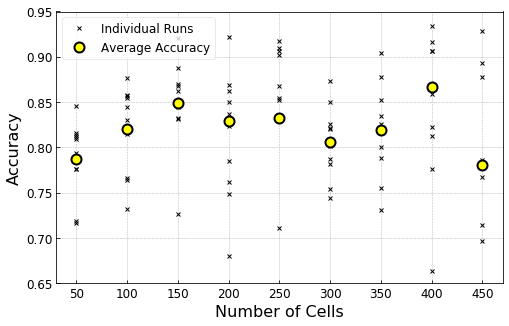

In [5]:
import matplotlib.pyplot as plt

def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]


plt.style.use('bmh')
plt.rcParams.update({"figure.figsize" : (8, 5),
                     "axes.facecolor" : "white",
                     "axes.edgecolor":  "black"})

plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
averages = [np.average(reject_outliers(np.array(i)[:,2],m=2)) for i in result_all]
#averages = averages = [np.average(np.array(i)[:,2]) for i in result_all]
bests = [np.max(np.array(i)[:,1]) for i in result_all]
stds = [np.std(np.array(i)[:,1]) for i in result_all]
xs = np.arange(50,500,50)
plt.plot(np.array(list_res)[:,0],np.array(list_res)[:,2],color='black',marker='x',markersize=4,linewidth=0,label = 'Individual Runs')
plt.plot(xs,averages,color='yellow',marker='o',linewidth = 0, markersize=10,mew=2,mec='black',label = 'Average Accuracy')
plt.ylim(0.65,0.95)
plt.legend(loc=2,frameon=True,fontsize=12)
plt.ylabel('Accuracy',fontsize=16)
plt.xlabel('Number of Cells',fontsize=16)
plt.savefig('/home/ubuntu/data/figures/Data_size.png',dpi=300)

In [ ]:
list_res

In [ ]:
all_images = filenames_preds.keys() 
result = []
#for cell in np.array(test_cells)[:,0]:
    cell_images = [image_path for image_path in all_images if cell in image_path]
    result.append(cell_images)


In [ ]:
np.array(test_cells)[:,0][-1]

In [ ]:
len(training_generator)